# Control Exercise 2: Dynamics and Control of a Continuous Fermentation

Import relevant packages and define parameters in a class:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp

In [2]:
class Parameters():
    def __init__(self):
        self.Ks = 0.1       # g/L
        self.Ko = 0.2e-03   # g/L
        self.Yxs = 0.4      # g/g
        self.A = 1e10       # Arrhenius Constant
        self.B = 3e90       # Arrhenius Constant
        self.Eg = 58        # Activation [h^-1]
        self.Gd = 550       # denaturation of protein
        self.R = 8.314e-3   # Gas Constant kJ/(K*mol)
        self.T = 293.15     # Temterature Kelvin
        self.mux = self.A*np.exp(-self.Eg/(self.R*self.T)) / (1+self.B*np.exp(-self.Gd/(self.R*self.T)))
        self.Po2 = 0.21     # Partial pressure of oxygen
        self.kh = 0.027*np.exp(1142/self.T)
        self.O_sat = self.Po2 * self.kh * 32/1000
        self.Osat = 0.008   # g/L
        self.kla = 250      # 1/h
        self.mu_max = 2.16  # 1/h
        self.Sf = 10        # g/L feed substrate conc. 
        self.V = 2          # L
        self.F = 0.5        # L/h

        self.x0 = 3     # g/L
        self.s0 = 0        # g/L
        self.p0 = 0         # g/L
        self.o0 = 0         # g/L

        self.t_end = 20      # h
        
par = Parameters()

Open loop simulation of the chemostat

In [3]:
def chemostat(t: float, y:list, par:dict) -> list:
    '''Open loop model of the chemostat, to be solved with solve_ivp, 3 states: x, s and o'''
    x, s, o = y
    
    mu = par.mux * (s/(par.Ks+s)) * (o/(par.Ko+o))
    dxdt = -par.F * x/par.V + mu*x
    dsdt = par.F*(par.Sf-s)/par.V - (mu*x)/par.Yxs
    dodt = (par.kla*(par.O_sat-o)) - par.F*o/par.V - ((1/par.Yxs)-1)*mu*x
    return [dxdt, dsdt, dodt]

In [8]:
## Open loop simulation 
ini = [par.x0, par.s0, par.o0]          # Initial values
sol = solve_ivp(chemostat, t_span=(0, par.t_end), y0=ini, args=(par,), method='RK45')     # call the ODE solver

Text(0, 0.5, 'Oxygen [g/L]')

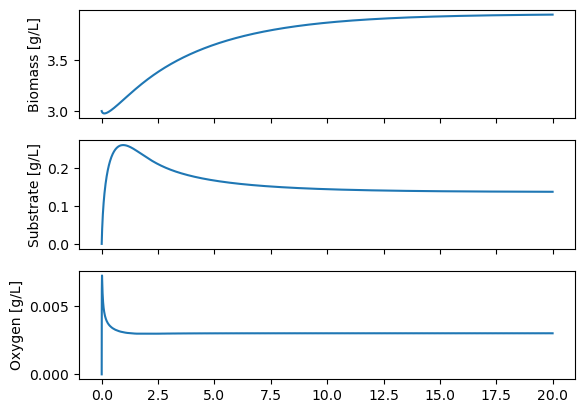

In [9]:
## Plotting the results
fig, ax = plt.subplots(3,1, sharex=True)
ax[0].plot(sol.t, sol.y[0,:])
ax[0].set_ylabel('Biomass [g/L]')
ax[1].plot(sol.t, sol.y[1,:])
ax[1].set_ylabel('Substrate [g/L]')
ax[2].plot(sol.t, sol.y[2,:])
ax[2].set_ylabel('Oxygen [g/L]')

Closed loop simulation with PI controller: 
- Controlled variable: o
- Manipulated variable: kla

In [38]:
def oSP(t:float) -> float:
    '''Define the setpoint for oxygen as function of time
    Step change from 0.005 to 0.006 at time t=5, and from 0.006 to 0.003 at t=10.'''
    if t > 10:
        output = 0.003
    elif t > 5:
        output = 0.006
    else:
        output = 0.005
    return output

def kla_PI(input:float, I:float, t:float) -> float:
    '''PI controller: takes in the value of o, and returns the actuation (kla)
    Here you can modify the controller parameters (Gain and tau_i)'''
    par.kla_Kc = -50000
    par.kla_TauI = 0.02
    
    u = par.kla + par.kla_Kc *(input-oSP(t)) + I
    return u

def chemostatPI(t:float, y:list, par:dict) -> list:
    '''Chemostat model with PI controller to control oxygen concentration by actuating on the kla'''
    x, s, o, oI = y
    # inputs:
    u1 = par.T
    u2 = par.F
    # u3 = par.kla
    u3 = kla_PI(o, oI, t) # Oxygen PID controller

    par.mux = par.A*np.exp(-par.Eg/(par.R*u1)) / (1+par.B*np.exp(-par.Gd/(par.R*u1)))
    par.kh = 0.027*np.exp(1142/u1)

    mu = par.mux * (s/(par.Ks+s)) * (o/(par.Ko+o))

    # system of ODE:
    dxdt = -u2 * x/par.V + mu*x
    dsdt = u2*(par.Sf-s)/par.V - (mu*x)/par.Yxs
    dodt = (u3*(par.O_sat-o)) - u2*o/par.V - ((1/par.Yxs)-1)*mu*x
    # integral part for the PI controller:
    doIdt = (par.kla_Kc/par.kla_TauI)*(o-oSP(t))
    return [dxdt, dsdt, dodt, doIdt]



In [39]:
## Closed loop simulation 
ini = [par.x0, par.s0, par.o0, 0]   # initial values (0 for the integral part of the PI controller)
sol = solve_ivp(chemostatPI, t_span=(0, par.t_end), y0=ini, args=(par,), method='RK45')   # call the ODE solver

Text(0.5, 0, 'Time [h]')

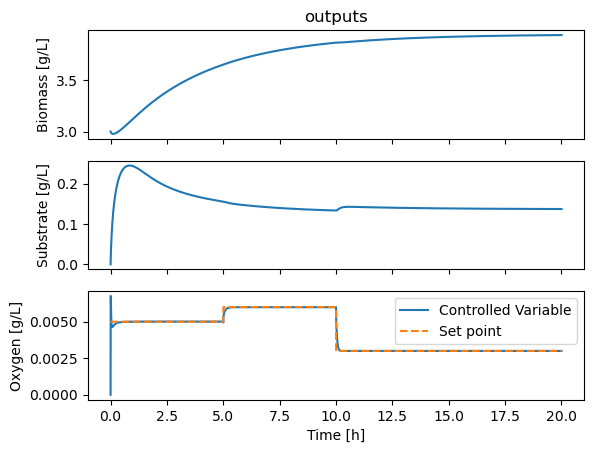

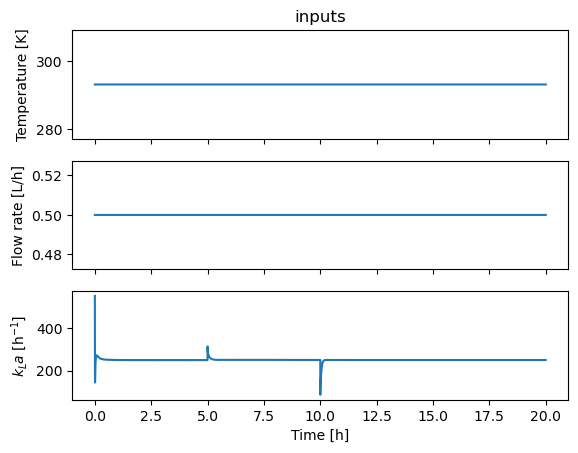

In [40]:
## Plotting the results: inputs and outputs
oSP_plot = [oSP(t) for t in sol.t] # Compute setpoint for plotting
# plotting the outputs
fig, ax = plt.subplots(3,1, sharex=True)
ax[0].plot(sol.t, sol.y[0,:])
ax[0].set_ylabel('Biomass [g/L]')
ax[0].set_title('outputs')
ax[1].plot(sol.t, sol.y[1,:])
ax[1].set_ylabel('Substrate [g/L]')
ax[2].plot(sol.t, sol.y[2,:], label='Controlled Variable')
ax[2].plot(sol.t, oSP_plot, '--', label='Set point')
ax[2].set_ylabel('Oxygen [g/L]')
ax[2].set_xlabel('Time [h]')
ax[2].legend()
# plotting the inputs
u1 = np.ones(len(sol.t))*par.T
u2 = np.ones(len(sol.t))*par.F
u3 = par.kla - 60000 *(sol.y[2,:]-oSP_plot)
fig, ax = plt.subplots(3,1, sharex=True)
ax[0].plot(sol.t, u1)
ax[0].set_ylabel('Temperature [K]')
ax[0].set_title('inputs')
ax[1].plot(sol.t, u2)
ax[1].set_ylabel('Flow rate [L/h]')
ax[2].plot(sol.t, u3)
ax[2].set_ylabel('$k_La$ [h$^{-1}$]')
ax[2].set_xlabel('Time [h]')